In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Parameters (adjust as needed)
stock = 'UAL'
data_file = f'cache/{stock}_max_1day_data.csv'
short_window = 5
mid_window = 15
long_window = 120
test_ratio = 0.15
val_ratio = 0.15
train_ratio = 1 - test_ratio - val_ratio
batch_size = 32
num_epochs = 50
early_stop_patience = 10
learning_rate = 0.001
hidden_size = 128

# 1. Data Loading and Preprocessing
df = pd.read_csv(data_file)
# most recent two years
df = df.iloc[-2*252:]
# Ensure positive values for Close
df = df[df['close'] > 0]
# Compute log returns
log_returns = np.log(df['close']).diff().dropna()
# standardize
log_returns = (log_returns - log_returns.mean()) / log_returns.std()


# Convert to numpy array
data_values = log_returns.values.astype(np.float32)

# 2. Creating Windowed Sequences
# We'll forecast the next day's return based on past windows.
# For the input at index i, 
# short term: [i-5:i], mid term: [i-30:i], long term: [i-180:i]
# target: data_values[i+1]

def create_sequences(data, short_w, mid_w, long_w):
    X_short, X_mid, X_long, Y = [], [], [], []
    max_w = long_w  # largest window
    # We must be able to go up to i+1 for the target, so upper bound is len(data)-1
    for i in range(max_w, len(data)-1):
        s_start = i - short_w
        m_start = i - mid_w
        l_start = i - long_w
        
        short_seq = data[s_start:i].reshape(-1, 1)
        mid_seq = data[m_start:i].reshape(-1, 1)
        long_seq = data[l_start:i].reshape(-1, 1)
        
        target = data[i+1]  # next day's return
        X_short.append(short_seq)
        X_mid.append(mid_seq)
        X_long.append(long_seq)
        Y.append([target])
    return np.array(X_short, dtype=np.float32), np.array(X_mid, dtype=np.float32), np.array(X_long, dtype=np.float32), np.array(Y, dtype=np.float32)

X_short_arr, X_mid_arr, X_long_arr, Y_arr = create_sequences(data_values, short_window, mid_window, long_window)

# 3. Train/Validation/Test Split (chronological)
n = len(Y_arr)
train_end = int(n * train_ratio)
val_end = int(n * (train_ratio + val_ratio))

X_short_train = X_short_arr[:train_end]
X_mid_train   = X_mid_arr[:train_end]
X_long_train  = X_long_arr[:train_end]
Y_train       = Y_arr[:train_end]

X_short_val = X_short_arr[train_end:val_end]
X_mid_val   = X_mid_arr[train_end:val_end]
X_long_val  = X_long_arr[train_end:val_end]
Y_val       = Y_arr[train_end:val_end]

X_short_test = X_short_arr[val_end:]
X_mid_test   = X_mid_arr[val_end:]
X_long_test  = X_long_arr[val_end:]
Y_test       = Y_arr[val_end:]

# 4. Create PyTorch Dataset and DataLoaders
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_X, mid_X, long_X, Y):
        self.short_X = short_X
        self.mid_X = mid_X
        self.long_X = long_X
        self.Y = Y
    def __len__(self):
        return len(self.Y)
    def __getitem__(self, idx):
        return (self.short_X[idx], self.mid_X[idx], self.long_X[idx], self.Y[idx])

train_dataset = MultiScaleStockDataset(X_short_train, X_mid_train, X_long_train, Y_train)
val_dataset   = MultiScaleStockDataset(X_short_val, X_mid_val, X_long_val, Y_val)
test_dataset  = MultiScaleStockDataset(X_short_test, X_mid_test, X_long_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 5. Define the Multi-Scale LSTM Model
class MultiScaleLSTM(nn.Module):
    def __init__(self, hidden_size=hidden_size, num_layers=2):
        super(MultiScaleLSTM, self).__init__()
        self.short_lstm = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.mid_lstm   = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.long_lstm  = nn.LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(3 * hidden_size, 1)

    def forward(self, short_x, mid_x, long_x):
        _, (short_h, _) = self.short_lstm(short_x)
        _, (mid_h, _)   = self.mid_lstm(mid_x)
        _, (long_h, _)  = self.long_lstm(long_x)

        short_feat = short_h[-1,:,:]
        mid_feat   = mid_h[-1,:,:]
        long_feat  = long_h[-1,:,:]

        combined = torch.cat([short_feat, mid_feat, long_feat], dim=1)
        output = self.fc(combined)
        return output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiScaleLSTM().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 6. Training with Validation and Early Stopping
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for short_x, mid_x, long_x, y in train_loader:
        short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(short_x, mid_x, long_x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for short_x, mid_x, long_x, y in val_loader:
            short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
            outputs = model(short_x, mid_x, long_x)
            loss = criterion(outputs, y)
            val_losses.append(loss.item())

    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == early_stop_patience:
            print("Early stopping triggered.")
            break

# Load the best model
model.load_state_dict(best_model_state)

# 7. Testing the Model
model.eval()
test_losses = []
with torch.no_grad():
    for short_x, mid_x, long_x, y in test_loader:
        short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
        outputs = model(short_x, mid_x, long_x)
        loss = criterion(outputs, y)
        test_losses.append(loss.item())

avg_test_loss = np.mean(test_losses)
print(f"Test MSE: {avg_test_loss:.4f}")

Epoch [1/50] Train Loss: 0.8610, Val Loss: 1.1207
Epoch [2/50] Train Loss: 0.8582, Val Loss: 1.1208
Epoch [3/50] Train Loss: 0.8531, Val Loss: 1.1326
Epoch [4/50] Train Loss: 0.8550, Val Loss: 1.1270
Epoch [5/50] Train Loss: 0.8511, Val Loss: 1.1253
Epoch [6/50] Train Loss: 0.8534, Val Loss: 1.1298
Epoch [7/50] Train Loss: 0.8498, Val Loss: 1.1264
Epoch [8/50] Train Loss: 0.8502, Val Loss: 1.1248
Epoch [9/50] Train Loss: 0.8540, Val Loss: 1.1335
Epoch [10/50] Train Loss: 0.8495, Val Loss: 1.1309
Epoch [11/50] Train Loss: 0.8474, Val Loss: 1.1276
Early stopping triggered.
Test MSE: 1.3701


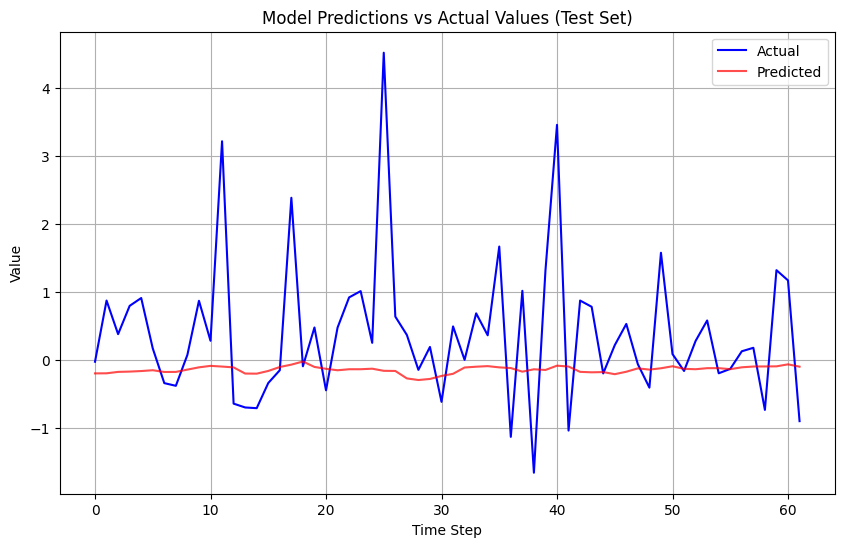

In [4]:
import matplotlib.pyplot as plt

# Switch model to evaluation mode
model.eval()

all_preds = []
all_actuals = []

with torch.no_grad():
    for short_x, mid_x, long_x, y in test_loader:
        short_x, mid_x, long_x, y = short_x.to(device), mid_x.to(device), long_x.to(device), y.to(device)
        outputs = model(short_x, mid_x, long_x)
        # Store predictions and actual values
        all_preds.append(outputs.cpu().numpy())
        all_actuals.append(y.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds, axis=0).squeeze()
all_actuals = np.concatenate(all_actuals, axis=0).squeeze()

# all_preds and all_actuals now hold the entire test set predictions and actuals
# If desired, you can plot them directly.

plt.figure(figsize=(10, 6))
plt.plot(all_actuals, label='Actual', color='blue')
plt.plot(all_preds, label='Predicted', color='red', alpha=0.7)
plt.title('Model Predictions vs Actual Values (Test Set)')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()